# Pairk - tutorial notebook

## introduction

This notebook will go over the basics of how to use the pairk library using an example set of sequences (comes pre-installed with pairk).

some text copied from the documentation

Pairk is a Python package for quantifying the conservation of motifs within intrinsically disordered regions (IDRs). It will run on any input protein sequences that you provide but it is designed for disordered regions, where multiple sequence alignments are particularly difficult to interpret and unreliable

the pairk method can be split into 2 steps, where each step has configurable options:

**Step 1: pairwise k-mer alignment**
- aligns all of the k-mers in the query sequence to all of the k-mers in the homolog sequences. For each query k-mer, the best matching k-mer from each homolog is selected and recorded. The results are returned in a `PairkAln` object which provides methods for accessing the results and writing/reading the results to/from files.
- The way in which the best matching query k-mer - homolog k-mer match is selected is adjustable. The currently implemented methods use either scoring matrices to score the match or use residue embedding distances from the ESM2 protein language model to score the match. Both methods are described in detail below

**Step 2: k-mer conservation**
- calculates conservation scores for each query k-mer using the results of Step 1. The conservation score results are stored in a `PairkConservation` object which also provides methods for plotting the results as well as writing/reading the results to/from files.
- The function used to score the conservation is adjustable.

make sure that pairk is installed before running this notebook (see the README.md file for installation instructions)

## import

Most of the functionality of pairk is accessed through the main pairk module, which can be imported directly.

In [1]:
import pairk

## load example data

pairk comes with some example data that we can use to test the methods. The example data is stored in the ``pairk.example1`` object.

In [2]:
ex1 = pairk.example1

This example is imported as a python object and holds data that is compatible with the main pairk methods

for example, we can access the IDR sequences in a dictionary with ``ex1.idr_dict``
or the query id with ``ex1.query_id``

In [3]:
for id, seq in ex1.idr_dict.items():
    print(id, seq)

9606_0:00294e TNLGTVNAAAPAQPSTGPKTGTTQPNGQIPQATHSVSAVLQEAQRHAETSKDKKPALGNHHDPAVPRAPHAPKSSLPPPPPVRRSSDTSGSPATPLKAKGTGGGGLPAPPDDFLPPPPPPPPLDDPELPPPPPDFMEPPPDFVPPPPPSYAGIAGSELPPPPPPPPAPAPAPVPDSARPPPAVAKRPPVPPKRQENPGHPGGAGGGEQDFMSDLMKALQKKRGNVS
9793_0:005123 TNVGTGNAATPAPPSTGLKTGTAQANGQIPQAAHSVSTVLNEADRQVDTPKDKKPALSNHDPGTPRAQHLPKSSLPPPPPVRRSSDTSSSPVMPAKGAAGGLPPLLDDSLPPPPPPPPLEDDELPPPPPDFDDAPPNFVPPPPPWDAGASLPPPPPPPPPALALAPEATKPSPVVAKRPPVPPKRQENPAPASGGGGGEQDFMSDLMKALQKKRGNVA
1706337_0:000fc7 TNLGTVNAAPPAPSSTGVKTGTTQANGQIPQAAHSMSTVLGEAQRQVETTKDKKSGLGSHDPGAPRAQTLPKSSLPPPPPVRRSSEVGCGSPGTSPKVKGAAAGFPAPPHDLLPPPPPPPPLEDDELPPPPPDFSDAPPDFVPPPPPPSFAGDAGSSLPPPPPPPALAPEAAKPTPVVVKRPPAPPKRQANPGPPGGGGGEQDFMSDLMKALQKKRSNMP
51337_0:001b5a TNLGTVNTATPAQPSTGFKTGSSQPNGQIPQTIPSVSAGLQEAQRHETIKDKKPSLSSTEPGAPRDPPGARSSLPPPPPPVRRSSDTCARAASPFPAPPDDLPPPPPPPPLEDPAMLPPPPALPEPPPDCVPPPPPPPGPGPQPARPSPGAGRRPPVPPKRQENPGLPSAGAGGEQDFMSDLMKALQKRGHMP
9568_0:004ae1 TNLGTVNAAAPAQPSTGPINGTAQPNGQMPQAAHSVSAVLQEAQRHAETSKVKPARPINGTAQPN

In [4]:
print(ex1.query_id)

9606_0:00294e


---

# Step 1: pairwise k-mer alignment

there are 2 main ways to run the k-mer alignment step:

* **Scoring matrix alignment**

   * These methods use a scoring matrix to score the query k-mer to homolog k-mer matches and select the best scoring match from each homolog.

* **Embedding distance alignment**

   * This method uses the Euclidean distance between the query k-mer residue embeddings from a protein large language model (such as ESM2) and homolog k-mer residue embeddings and selects the lowest distance match from each homolog.


## 1.a Scoring matrix alignment

There are 2 implementations of the scoring matrix method:

* `pairk.pairk_alignment` - the original implementation. This is a bit slow because it does an exhaustive comparison of all k-mers in the query sequence with all k-mers in the homologs.

* `pairk.pairk_alignment_needleman` - a faster implementation that uses the Needleman-Wunsch algorithm (as implemented in Biopython) to align the k-mers. This is faster and should yield the same results.

inputs common to both functions are:

* ``idr_dict``: a dictionary of IDR sequences, where the keys are the sequence ids and the values are the sequences. Includes the query sequence (the sequence to split into k-mers and align with the homologs).
* ``query_id``: a query sequence id (the sequence to split into k-mers and align with the homologs). This id should be present in ``idr_dict``.
* ``k``: the length of the k-mers

These inputs can be generated many ways, and there are helper functions in the pairk library to help with this (see functions in ``pairk.utilities``). 

### 1.a.1 Scoring matrix - `pairk.pairk_alignment` - slower

In [5]:
pairk.pairk_alignment?

Signature:
pairk.pairk_alignment(
    idr_dict: dict[str, str],
    query_id: str,
    k: int,
    matrix_name: str = 'EDSSMat50',
) -> pairk.backend.tools.pairwise_tools.PairkAln
Docstring:
run pairwise k-mer alignment method using an exhaustive comparison of k-mers.
Each query k-mer is scored against each ortholog k-mer to find the best matching
ortholog k-mer in each ortholog. If a ortholog IDR is shorter than the k-mer, a
string of "-" characters ("-"\*k) is assigned as the best matching ortholog k-mer for that
ortholog.

**Note**: if there are multiple top-scoring matches, only one is returned.

Parameters
----------
idr_dict : dict[str, str]
    input sequences in dictionary format with the key being the sequence id and
    the value being the sequence as a string
query_id : str
    the id of the query sequence within the `idr_dict` dictionary
k : int
    the length of the k-mers to use for the alignment
matrix_name : str, optional
    The name of the scoring matrix to use in the

In [6]:
aln_results = pairk.pairk_alignment(
    idr_dict=ex1.idr_dict,
    query_id=ex1.query_id,
    k=5,
)

To specify the scoring matrix used, you can pass the name of the matrix to the ``matrix_name`` argument.

To see the available matrices, use the `pairk.print_available_matrices()` function.

In [2]:
pairk.print_available_matrices()

biopython-builtin matrices (aligner compatible):
BENNER22
BENNER6
BENNER74
BLASTN
BLASTP
BLOSUM45
BLOSUM50
BLOSUM62
BLOSUM80
BLOSUM90
DAYHOFF
FENG
GENETIC
GONNET1992
HOXD70
JOHNSON
JONES
LEVIN
MCLACHLAN
MDM78
MEGABLAST
NUC.4.4
PAM250
PAM30
PAM70
RAO
RISLER
SCHNEIDER
STR
TRANS

other matrices:
grantham_similarity_normx100_aligner_compatible
BLOSUM62
EDSSMat50
grantham
grantham_similarity_norm


### Scoring matrix - `pairk.pairk_alignment_needleman` - faster

In [8]:
pairk.pairk_alignment_needleman?

Signature:
pairk.pairk_alignment_needleman(
    idr_dict: dict[str, str],
    query_id: str,
    k: int,
    aligner: Bio.Align.PairwiseAligner | None = None,
    matrix_name: str = 'EDSSMat50',
) -> pairk.backend.tools.pairwise_tools.PairkAln
Docstring:
run pairwise k-mer alignment method using the needleman-wunsch algorithm as
implemented in Biopython. Each query k-mer is scored against each ortholog
k-mer to find the best matching ortholog k-mer in each ortholog. If a ortholog
IDR is shorter than the k-mer, a string of "-" characters  ("-"\*k) is
assigned as the best matching ortholog k-mer for that ortholog

**Note**: if there are multiple top-scoring matches, only one is returned.

Parameters
----------
idr_dict : dict[str, str]
    input sequences in dictionary format with the key being the sequence id and
    the value being the sequence as a string
query_id : str
    the id of the query sequence within the `idr_dict` dictionary
k : int
    the length of the k-mers to use for th

This method returns the same results as ``pairk.pairk_alignment``, but it is faster.

The difference is that the ``pairk.pairk_alignment_needleman`` method uses the Needleman-Wunsch algorithm to align the k-mers, while the ``pairk.pairk_alignment`` method uses a scoring matrix to exhaustively score the k-mer matches. ``pairk.pairk_alignment_needleman`` ensures that the alignment is gapless by using an extremely high gap opening and extension penalty (-1000000). This will ensure that the alignment is gapless, unless you use a really unusual scoring matrix with very high scores.

This method takes similar arguments as ``pairk.pairk_alignment``, accept that the ``pairk.pairk_alignment_needleman`` method takes an optional ``aligner`` argument. This allows you to create the aligner before calling the method, which is useful if you want to do multiprocessing, so that you're not creating a new aligner for each process. I've found that if you create a new aligner for each process, the memory usage gets very high, as if the memory isn't being released until the entire script finishes

The ``aligner`` object can be created via the ``pairk.create_aligner`` function. This function takes the name of the scoring matrix as an argument and returns the aligner object. If you don't pass the ``aligner`` argument to the ``pairk.pairk_alignment_needleman`` method, it will create a new aligner using the ``matrix_name`` argument. This is fine if you're not doing multiprocessing. If you are doing multiprocessing, I would suggest creating the aligner before calling the method. If the ``aligner`` argument is passed, the ``matrix_name`` argument is ignored.


In [9]:
aligner = pairk.make_aligner('EDSSMat50')

In [10]:
aln_results_needleman = pairk.pairk_alignment_needleman(
    idr_dict=ex1.idr_dict,
    query_id=ex1.query_id,
    k=5,
    aligner=aligner
)

results are the same as the `pairk.pairk_alignment` method in this case

In [11]:
(aln_results.position_matrix == aln_results_needleman.position_matrix).all().all()

True

## Embedding distance alignment

This method uses the Euclidean distance between the query k-mer residue embeddings and homolog k-mer residue embeddings and selects the lowest distance match from each homolog. For each homolog, it calculates the distance between the query k-mer and each k-mer in the homolog. It then selects the k-mer with the lowest distance as the best match.

### embedding distance - `pairk.pairk_alignment_embedding_distance`

In [12]:
pairk.pairk_alignment_embedding_distance?

Signature:
pairk.pairk_alignment_embedding_distance(
    full_length_sequence_dict: dict[str, str],
    idr_position_map: dict[str, list[int]],
    query_id: str,
    k: int,
    mod: pairk.backend.tools.esm_tools.ESM_Model,
    device: str = 'cuda',
    precomputed_embeddings: None | dict[str, torch.Tensor] = None,
)
Docstring:
run pairwise k-mer alignment method using sequence embeddings from the
ESM2 protein large language model to find the best k-mer matches from each
homolog. If a ortholog IDR is shorter than the k-mer, a string of "-"
characters ("-"\*k) is assigned as the best matching ortholog k-mer for that
ortholog

**Note**: if there are multiple top-scoring matches, only one is returned.

Sequence embeddings are calculated for each full length sequence in the
input dictionary. The `idr_position_map` dictionary is used to extract the
IDR and the IDR embeddings from each sequence. The Euclidean distance is
calculated between each query k-mer embedding slice and each ortholog 

This method generates residue embeddings using the ESM2 protein large language model. 

Because residue embeddings are used, the inputs are slightly different than the previous methods. 

The inputs are:

* ``full_length_sequence_dict``: a dictionary of full-length sequences, where the keys are the sequence ids and the values are the sequences. This is used to generate the embeddings.
* ``idr_position_map``: a dictionary where the keys are the full-length sequence ids and the values are the start and end positions of the IDR in the full-length sequence (using python indexing). This is used to slice out the IDR embeddings/sequences from the full-length embeddings/sequences.
* ``query_id``: a query sequence id (the sequence to split into k-mers and align with the homologs). This id should be present in ``idr_position_map`` and ``full_length_sequence_dict``.
* ``k`` - the length of the k-mers
* ``mod`` - a ``pairk.ESM_Model`` object. This is the ESM2 model used to generate the embeddings. The code for the ESM2 embeddings is adapted from the kibby conservation tool [link](https://github.com/esbgkannan/kibby) DOI: 10.1093/bib/bbac599
* ``device`` - whether to use cuda or your cpu for pytorch, should be either "cpu" or "cuda". (default is "cuda"). If "cuda" fails, it will default to "cpu". This argument is passed to the ``pairk.ESM_Model.encode`` method

Full length sequences (``full_length_sequence_dict``) are required to generate the embeddings because each embedding is dependent upon the neighboring residues. The embeddings for just an IDR are different than the embeddings for a full length sequences. Thus, the full length embeddings are gathered first, and then the IDR embeddings are sliced out for the k-mer alignment. 

The ``idr_position_map`` is used to slice out the IDR embeddings, and there must be IDR positions for each sequence in the input sequence set.

Our example has both of those

In [13]:
ex1.full_length_dict

{'9606_0:00294e': 'MGESSEDIDQMFSTLLGEMDLLTQSLGVDTLPPPDPNPPRAEFNYSVGFKDLNESLNALEDQDLDALMADLVADISEAEQRTIQAQKESLQNQHHSASLQASIFSGAASLGYGTNVAATGISQYEDDLPPPPADPVLDLPLPPPPPEPLSQEEEEAQAKADKIKLALEKLKEAKVKKLVVKVHMNDNSTKSLMVDERQLARDVLDNLFEKTHCDCNVDWCLYEIYPELQIERFFEDHENVVEVLSDWTRDTENKILFLEKEEKYAVFKNPQNFYLDNRGKKESKETNEKMNAKNKESLLEESFCGTSIIVPELEGALYLKEDGKKSWKRRYFLLRASGIYYVPKGKTKTSRDLACFIQFENVNIYYGTQHKMKYKAPTDYCFVLKHPQIQKESQYIKYLCCDDTRTLNQWVMGIRIAKYGKTLYDNYQRAVAKAGLASRWTNLGTVNAAAPAQPSTGPKTGTTQPNGQIPQATHSVSAVLQEAQRHAETSKDKKPALGNHHDPAVPRAPHAPKSSLPPPPPVRRSSDTSGSPATPLKAKGTGGGGLPAPPDDFLPPPPPPPPLDDPELPPPPPDFMEPPPDFVPPPPPSYAGIAGSELPPPPPPPPAPAPAPVPDSARPPPAVAKRPPVPPKRQENPGHPGGAGGGEQDFMSDLMKALQKKRGNVS',
 '9793_0:005123': 'MGESNEDIDQMFSHLLGEMDLLTKSLGVDTLPPPDPKPPRAEFNFSVGFKDLNESLNALEDQDLDALMADLVADISEAEQRTIQAQRESSQDQLHSASLEKSNFSGAASLGYGADMAIMSTSQYGDELPPPPADPMLDLPLPPPPPEPLSQEEQEAAAKADKIKLALEKLKEAKVKKLVVKVHMNDNSTKSLMVDERQLARDILDNLFEKTHCDCNIDWCLYEIYPELQIERFFEDHENVVEVLSDWTRDTENKVVFLEKEEKYAVFKNPQNFYLDNKGKKESKETNGKMNAK

In [14]:
ex1.idr_position_map

{'9606_0:00294e': [440, 665],
 '9793_0:005123': [440, 657],
 '1706337_0:000fc7': [457, 676],
 '51337_0:001b5a': [440, 632],
 '9568_0:004ae1': [426, 564],
 '43346_0:004190': [492, 656],
 '885580_0:00488c': [440, 524],
 '10181_0:00305d': [484, 578],
 '1415580_0:000900': [439, 679],
 '61221_0:00105a': [440, 678],
 '7897_0:0033c5': [442, 653],
 '8407_0:002bff': [430, 663],
 '173247_0:004550': [432, 680],
 '30732_0:0046dd': [425, 663],
 '241271_0:0048e4': [435, 685],
 '8103_0:0045e4': [429, 673],
 '56723_0:00152f': [430, 685],
 '210632_0:004c0c': [429, 685],
 '31033_0:00264e': [420, 658],
 '63155_0:004c86': [431, 667],
 '7994_0:004d71': [439, 676],
 '109280_0:00369f': [418, 723],
 '150288_0:004e5a': [376, 424]}

The ``mod`` input is required so that you can preload the ESM model before running the method. You preload the ESM model with ``pairk.ESM_Model()``

In [15]:
pairk.ESM_Model?

Init signature: pairk.ESM_Model(model_name: str = 'esm2_t33_650M_UR50D', threads: int = 1)
Docstring:     
This was adapted from the kibby conservation method: DOI: 10.1093/bib/bbac599.
see https://github.com/esbgkannan/kibby

Class that loads a specified ESM model. Provides a method for encoding protein sequences.

available models:
- esm1b_t33_650M_UR50S

- esm2_t6_8M_UR50D

- esm2_t12_35M_UR50D

- esm2_t30_150M_UR50D

- esm2_t33_650M_UR50D (default)

- esm2_t36_3B_UR50D



Attributes
----------
model_name : str
    the name of the model that was loaded.
threads : int
    the number of threads for pytorch to use, by default 1.
File:           ~/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/tools/esm_tools.py
Type:           type
Subclasses:     

you can use pre-generated embeddings by providing them in a dictionary format to the `precomputed_embeddings` argument. The keys should be the sequence ids and the values should be full length sequence embedding tensors. For each sequence, the tensor.shape[0] should be equal to l+2, where l is the length of the full length sequence. The +2 is for the start and end tokens. If you provide precomputed embeddings, the `mod` and `device` arguments are ignored.

The ``pairk.pairk_alignment_embedding_distance`` method returns a ``PairkAln`` object, just like the previous methods

example usage: loading the ESM2 model and running the method

In [16]:
mod = pairk.ESM_Model(threads=4)
aln_results_embedding = pairk.pairk_alignment_embedding_distance(
    full_length_sequence_dict=ex1.full_length_dict,
    idr_position_map=ex1.idr_position_map,
    query_id=ex1.query_id,
    k=5,
    mod=mod,
    device="cpu"
)

## k-mer alignment results

The results of the above pairwise k-mer alignment methods are returned as a ``PairkAln`` object.

In [17]:
pairk.PairkAln?

Init signature:
pairk.PairkAln(
    orthokmer_df: pandas.core.frame.DataFrame,
    pos_df: pandas.core.frame.DataFrame,
    score_df: pandas.core.frame.DataFrame | None = None,
)
Docstring:     
A class to store the results of the pairwise alignment.

The primary data is stored in pandas dataframes. All dataframes have the
same structure. One column is the query k-mer sequence
('query_kmer'). The other columns are named as the ortholog sequence
ids. The dataframe indexes are the query k-mer start position in the
query sequence.

Attributes
----------
orthokmer_matrix : pd.DataFrame
    the best scoring k-mer from each ortholog for each query k-mer.
position_matrix : pd.DataFrame
    the start position of the best scoring k-mer from each ortholog for
    each query k-mer.
score_matrix : pd.DataFrame | None
    the alignment scores for each k-mer in the query sequence against
    the corresponding best matching ortholog k-mer.
query_kmers : list[str]
    the list of query k-mers that wer

The actual "alignments" are stored as matrices in the ``PairkAln`` object. The main matrices are:

* orthokmer_matrix - the best matching k-mers from each homolog for each query k-mer
* position_matrix - the positions of the best matching k-mers in the homologs
* score_matrix - the scores of the best matching k-mers

Each matrix is a pandas DataFrame where the index is the start position of the k-mer in the query sequence. The columns are the query k-mers + the homolog sequence ids.

The ``PairkAln`` object has some useful methods for accessing the data. For example, you can get the best matching k-mers for a query k-mer by its position in the query sequence using the ``.get_pseudo_alignment`` method (or by directly accessing the dataframes). You can also plot the matrices as heatmaps, save the results to a json file, and load the results from that file


example: accessing the DataFrames from the ``PairkAln`` object directly

In [18]:
aln_results.score_matrix

,query_kmer,9793_0:005123,1706337_0:000fc7,51337_0:001b5a,9568_0:004ae1,43346_0:004190,885580_0:00488c,10181_0:00305d,1415580_0:000900,61221_0:00105a,...,30732_0:0046dd,241271_0:0048e4,8103_0:0045e4,56723_0:00152f,210632_0:004c0c,31033_0:00264e,63155_0:004c86,7994_0:004d71,109280_0:00369f,150288_0:004e5a
0,TNLGT,22.0,28.0,28.0,28.0,28.0,28.0,28.0,10.0,9.0,...,13.0,12.0,13.0,13.0,9.0,8.0,13.0,8.0,14.0,9.0
1,NLGTV,16.0,29.0,29.0,29.0,29.0,29.0,29.0,16.0,8.0,...,11.0,13.0,11.0,13.0,7.0,7.0,11.0,6.0,14.0,10.0
2,LGTVN,16.0,29.0,29.0,29.0,29.0,29.0,23.0,10.0,7.0,...,11.0,8.0,9.0,10.0,7.0,8.0,10.0,8.0,16.0,4.0
3,GTVNA,19.0,26.0,23.0,26.0,26.0,23.0,17.0,15.0,10.0,...,11.0,9.0,10.0,8.0,8.0,9.0,11.0,9.0,9.0,6.0
4,TVNAA,18.0,25.0,22.0,25.0,22.0,22.0,16.0,14.0,11.0,...,11.0,9.0,8.0,12.0,8.0,11.0,11.0,10.0,11.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,LQKKR,31.0,31.0,19.0,31.0,31.0,3.0,9.0,31.0,24.0,...,26.0,19.0,19.0,19.0,26.0,19.0,26.0,19.0,26.0,0.0
218,QKKRG,29.0,23.0,16.0,29.0,29.0,5.0,3.0,29.0,22.0,...,23.0,22.0,16.0,16.0,29.0,17.0,29.0,22.0,23.0,-1.0
219,KKRGN,29.0,23.0,18.0,29.0,29.0,2.0,2.0,23.0,21.0,...,17.0,23.0,15.0,17.0,23.0,18.0,21.0,22.0,14.0,-1.0
220,KRGNV,29.0,19.0,20.0,29.0,29.0,8.0,8.0,17.0,15.0,...,9.0,17.0,8.0,11.0,14.0,9.0,13.0,14.0,11.0,2.0


example: access the best matching k-mers for the query k-mer at position 4:

In [19]:
aln_results.orthokmer_matrix.loc[4]

query_kmer          TVNAA
9793_0:005123       TGNAA
1706337_0:000fc7    TVNAA
51337_0:001b5a      TVNTA
9568_0:004ae1       TVNAA
43346_0:004190      TVNAV
885580_0:00488c     TVNTA
10181_0:00305d      TVSTA
1415580_0:000900    NVNAN
61221_0:00105a      AVSAG
7897_0:0033c5       TVSAS
8407_0:002bff       SQNVA
173247_0:004550     TPNQA
30732_0:0046dd      TVKAK
241271_0:0048e4     PVNSF
8103_0:0045e4       PLNAL
56723_0:00152f      TAAAA
210632_0:004c0c     TIKAK
31033_0:00264e      TIKAS
63155_0:004c86      TVKAK
7994_0:004d71       TSNTS
109280_0:00369f     TTAAA
150288_0:004e5a     NLNSQ
Name: 4, dtype: object

example: access the best matching k-mers for the query k-mer at position 4 using the ``get_pseudo_alignment`` method.
(the returned list includes the query k-mer sequence)

In [20]:
aln_results.get_pseudo_alignment(4)

['TVNAA',
 'TGNAA',
 'TVNAA',
 'TVNTA',
 'TVNAA',
 'TVNAV',
 'TVNTA',
 'TVSTA',
 'NVNAN',
 'AVSAG',
 'TVSAS',
 'SQNVA',
 'TPNQA',
 'TVKAK',
 'PVNSF',
 'PLNAL',
 'TAAAA',
 'TIKAK',
 'TIKAS',
 'TVKAK',
 'TSNTS',
 'TTAAA',
 'NLNSQ']

you can search for a specific kmer to get its positions. You can then use the positions to query the matrices.

In [21]:
aln_results.find_query_kmer_positions('LPPPP')

[75, 113, 127, 157]

In [22]:
aln_results.get_pseudo_alignment(75)

['LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'PPMPP',
 'LPPPP',
 'LPDRP',
 'APSPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'LPPPP',
 'IPPPP']

In [23]:
aln_results.orthokmer_matrix.loc[[75, 113, 127, 157]].T

,75,113,127,157
query_kmer,LPPPP,LPPPP,LPPPP,LPPPP
9793_0:005123,LPPPP,LPPPP,LPPPP,LPPPP
1706337_0:000fc7,LPPPP,LPPPP,LPPPP,LPPPP
51337_0:001b5a,LPPPP,LPPPP,LPPPP,LPPPP
9568_0:004ae1,PPMPP,PPMPP,PPMPP,PPMPP
43346_0:004190,LPPPP,LPPPP,LPPPP,LPPPP
885580_0:00488c,LPDRP,LPDRP,LPDRP,LPDRP
10181_0:00305d,APSPP,APSPP,APSPP,APSPP
1415580_0:000900,LPPPP,LPPPP,LPPPP,LPPPP
61221_0:00105a,LPPPP,LPPPP,LPPPP,LPPPP


Note - the k-mers are defined by position rather than sequence. You could easily make a variant of this method that uses the unique sequences instead. It would make the method slightly faster. <br>The reason that I didn't do this is because I wanted to mimic the LLM embedding version of Pairk, where identical k-mers have different embeddings and thus are treated as different k-mers.<br>Inclusion of duplicate k-mers does alter the final z-scores, so it's something to be aware of.

example: plot a heatmap of the matrices

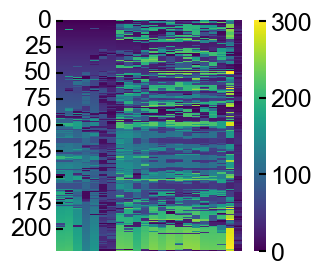

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3,3))
aln_results.plot_position_heatmap(ax)
ax.xaxis.set_visible(False)

example: save the results to a file using ``write_to_file`` and load them back into python using ``from_file``:

In [25]:
aln_results.write_to_file('./aln_results.json')
aln_results = pairk.PairkAln.from_file('./aln_results.json')
print(aln_results)

PairkAln object for 222 query k-mers
query sequence: TNLGTVNAAAPAQPSTGPKTGTTQPNGQIPQATHSVSAVLQEAQRHAETSKDKKPALGNHHDPAVPRAPHAPKSSLPPPPPVRRSSDTSGSPATPLKAKGTGGGGLPAPPDDFLPPPPPPPPLDDPELPPPPPDFMEPPPDFVPPPPPSYAGIAGSELPPPPPPPPAPAPAPVPDSARPPPAVAKRPPVPPKRQENPGHPGGAGGGEQDFMSDLMKALQKKRGNVS
k-mer length: 5



---

# Step 2: k-mer conservation

In this step, the query k-mer and the best matching homolog k-mers are treated as a gapless multiple sequence alignment with 'k' columns, which we call a "pseudo-MSA". Column-wise conservation scores are calculated for each position in each pseudo-MSA. All of the conservation scores are then converted to z-scores to give the relative conservation of each k-mer position compared to the rest of the query IDR. The conservation score results are stored in a ``PairkConservation`` object which also provides methods for plotting the results and reading/writing the results from/to files.


## pairk.calculate_conservation

the main method for Step 2 is the ``pairk.calculate_conservation`` method. It simply takes the ``PairkAln`` object as input, along with a columnwise conservation scoring function and returns a ``PairkConservation`` object.

In [26]:
pairk.calculate_conservation?

Signature:
pairk.calculate_conservation(
    pairk_aln_results: pairk.backend.tools.pairwise_tools.PairkAln,
    score_func: Callable = <function property_entropy at 0x1628bec00>,
) -> pairk.backend.conservation.kmer_conservation.PairkConservation
Docstring:
calculate the conservation scores for the k-mers in the PairkAln object. calculates the conservation scores and z-scores for each k-mer position.

Parameters
----------
pairk_aln_results : PairkAln
    the results of the pairk alignment step as a pairk.PairkAln object.
score_func : Callable, optional
    A function to calculate conservation scores in a columnwise manner, by
    default it is the property_entropy function from Capra and Singh 2007,
    DOI: 10.1093/bioinformatics/btm270 located in the
    `pairk.pairk_conservation.capra_singh_functions` module.

Returns
-------
PairkConservation
    PairkConservation object containing the conservation scores and z-scores for each k-mer position.
File:      ~/Dropbox (MIT)/work/07-SL

The columnwise conservation scoring function can be any function that takes a string of residues (a column of an alignment) as an input and returns a float (conservation score). You can use custom functions here, but pairk comes with a few built-in functions from Capra and Singh 2007 (DOI: 10.1093/bioinformatics/btm270) available in the ``pairk.capra_singh_functions`` module. The ``pairk.capra_singh_functions.property_entropy`` is the default function used by ``pairk.calculate_conservation``.


In [27]:
pairk.capra_singh_functions?

Type:        module
String form: <module 'pairk.backend.conservation.capra_singh_functions' from '/Users/jackson/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/conservation/capra_singh_functions/__init__.py'>
File:        ~/Dropbox (MIT)/work/07-SLiM_bioinformatics/11-pairk/pairk/backend/conservation/capra_singh_functions/__init__.py
Docstring:  
Module to hold conservation methods from Capra and Singh 2007, DOI: 10.1093/bioinformatics/btm270

The methods in this module are used to calculate column-wise conservation scores and take a string of characters (an alignment column) as input.
Conservation scores are calculated and normalized to a range of 0 to 1, where 0 is the least conserved and 1 is the most conserved.
By default, gaps are penalized by multiplying the final conservation score by the fraction of non-gap characters in the column.

Methods:
--------
property_entropy : Callable
    Calculate the property entropy of a column of sequence characters
shannon_entr

Example

In [28]:
aln_results = pairk.pairk_alignment(
    idr_dict=ex1.idr_dict,
    query_id=ex1.query_id,
    k=5,
    matrix_name="EDSSMat50"
)
conservation_results = pairk.calculate_conservation(
    aln_results,
)

example usage: using a different conservation scoring function:


In [29]:
from pairk import capra_singh_functions
column = 'NNNNNNNNNKNSNNNNNNNNSSN'
print(capra_singh_functions.shannon_entropy(column))

0.8161170118989496


In [30]:
aln_results = pairk.pairk_alignment(
    idr_dict=ex1.idr_dict,
    query_id=ex1.query_id,
    k=5,
)
conservation_results = pairk.calculate_conservation(
    pairk_aln_results=aln_results,
    score_func=capra_singh_functions.shannon_entropy
)

## k-mer conservation results

The ``pairk.calculate_conservation`` method returns a ``PairkConservation`` object.

In [31]:
pairk.PairkConservation?

Init signature:
pairk.PairkConservation(
    orthokmer_arr: numpy.ndarray,
    score_arr: numpy.ndarray,
    z_score_arr: numpy.ndarray,
)
Docstring:     
a class to store the results of the conservation scoring

The methods can be used to create plots of the conservation scores and
sequence logos.

Attributes
----------
orthokmer_arr : np.ndarray
    the best scoring k-mer from each ortholog for each query k-mer.
score_arr : np.ndarray
    the conservation scores for each k-mer position.
z_score_arr : np.ndarray
    the z-scores for each k-mer position.
query_kmers : list[str]
    the query k-mers.
query_sequence : str
    the query sequence.
k : int
    the length of the query k-mers.
bg_scores : np.ndarray
    the background conservation scores used to calculate the z-scores. This
    is just a flattened version of the score_arr.
n_bg_scores : int
    the number of background scores used to calculate the z-scores.
n_bg_kmers : int
    the number of k-mers used to calculate the z-sco

The returned ``PairkConservation`` object has matrices with similar structure as ``PairkAln`` object matrices, except that they are numpy arrays instead of pandas dataframes.

* orthokmer_arr - the best matching k-mers from each homolog for each query k-mer - analogous to the orthokmer_matrix in the ``PairkAln`` object
* score_arr - the conservation scores for each position in the pseudo-MSA of each query k-mer
* z_score_arr - the conservation score z-scores for each position in the pseudo-MSA of each query k-mer

If ``n`` is the number of k-mers in the query sequence and ``m`` is the number of homologs (including the query sequence), the matrices will have the dimensions:

* orthokmer_arr: (n, m)
* score_arr: (n, k)
* z_score_arr: (n, k)


### accessing the results

The row index of the arrays correspond to the starting position of the query k-mer in the query IDR. 

For example, to access the conservation scores for the k-mer at position 4 in the query IDR, you would access the 4th row of the arrays: ``.score_arr[4, :]``.

In [32]:
k_mer_position = 4
print(f"query k-mer at position {k_mer_position}: {conservation_results.orthokmer_arr[k_mer_position, 0]}")
print(f"pseudo-MSA for the query k-mer at position {k_mer_position} (including the query k-mer): {conservation_results.orthokmer_arr[k_mer_position, :]}")
print(f"scores for each position of the k-mer at position {k_mer_position}:")
print(conservation_results.score_arr[k_mer_position, :])
print(f"z scores for each position of the k-mer at position {k_mer_position}:")
print(conservation_results.z_score_arr[k_mer_position, :])

query k-mer at position 4: TVNAA
pseudo-MSA for the query k-mer at position 4 (including the query k-mer): ['TVNAA' 'TGNAA' 'TVNAA' 'TVNTA' 'TVNAA' 'TVNAV' 'TVNTA' 'TVSTA' 'NVNAN'
 'AVSAG' 'TVSAS' 'SQNVA' 'TPNQA' 'TVKAK' 'PVNSF' 'PLNAL' 'TAAAA' 'TIKAK'
 'TIKAS' 'TVKAK' 'TSNTS' 'TTAAA' 'NLNSQ']
scores for each position of the k-mer at position 4:
[0.69754401 0.48589838 0.6438038  0.64920359 0.44093655]
z scores for each position of the k-mer at position 4:
[ 0.17610372 -1.01357184 -0.12597394 -0.09562132 -1.26630561]


### plotting the results

There are several plotting functions available from the ``pairk.PairkConservation`` object shown below.

example usage: plotting background score distributions

<Axes: xlabel='Conservation score', ylabel='Count'>

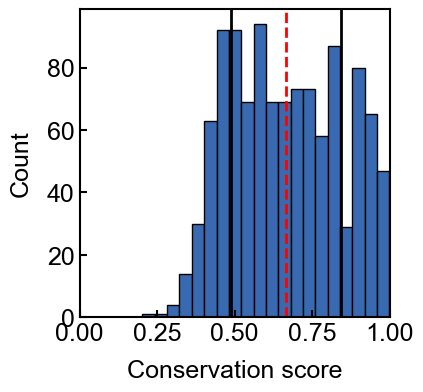

In [33]:
conservation_results.plot_background_distribution()

example usage: plotting conservation scores


Text(0.5, 1.0, 'conservation z-scores')

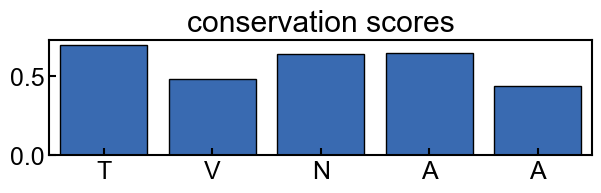

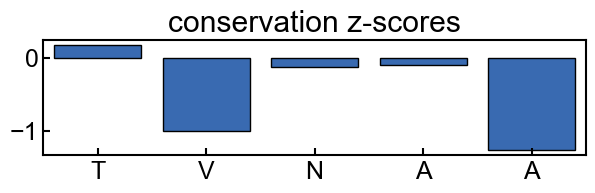

In [34]:
fig, ax = plt.subplots(figsize=(7,1.5))
conservation_results.plot_score_barplot(k_mer_position, ax=ax)
ax.set_title('conservation scores')
fig, ax = plt.subplots(figsize=(7,1.5))
conservation_results.plot_score_barplot(k_mer_position, score_type='z_score', ax=ax)
ax.set_title('conservation z-scores')

example usage: display a pseudo-MSA as a sequence logo

<Axes: >

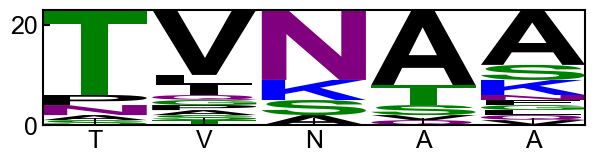

In [35]:
fig, ax = plt.subplots(figsize=(7,1.5))
conservation_results.plot_sequence_logo(k_mer_position, ax=ax)

/var/folders/q4/k476_qrd3jvdvzwd6lq30kqc0000gn/T/ipykernel_96254/1814068924.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.5, w_pad=0.5)


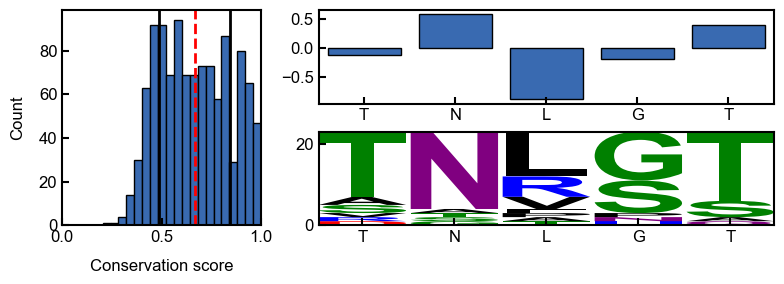

In [36]:
plt.rcParams.update({'font.size': 12})
fig, axd = conservation_results.plot_conservation_mosaic(
    position=0,
    score_type='z_score',
    figsize=(8, 3)
)
plt.tight_layout(h_pad=0.5, w_pad=0.5)

### getting the average conservation score for a query k-mer

You can use the ``get_average_score`` function to get the average conservation score for a k-mer position.



example: get the average conservation score for the query k-mer at position 4

In [37]:
conservation_results.get_average_score(4, score_type='z_score')

-0.4650737963634926

The ``get_average_score`` function takes a ``position_mask`` as an optional argument that will only consider the conservation scores for the positions in the mask when calculating the average score. This is useful if you want to exclude certain positions from the average score calculation.

example: get the average conservation score for the query k-mer at position 0, but only consider the conservation scores for positions 1, and 3 within the k-mer

In [38]:
position_mask = [0, 1, 0, 1, 0]
conservation_results.get_average_score(0, score_type='z_score', position_mask=position_mask)

0.197148283025409

You could also do a weighted average from manually extracted conservation scores.

example: get the weighted average conservation score for the query k-mer at position 0 (using some arbitrary weights)

In [39]:
import numpy as np
np.average(conservation_results.z_score_arr[0, :], weights=[0.1, 1, 0.5, 1, 10])

0.31155698039226354

### Writing and Reading Results from Files

You can save the results to a file with ``write_results_to_file`` and load them back in with ``read_results_from_file``.

example usage: save the results to a file and load them back in

In [40]:
conservation_results.write_results_to_file('./conservation_results.npz')

conservation_results.read_results_from_file('./conservation_results.npz')

PairkConservation object
222 query kmers x 23 orthologs
kmer length - 5
1110 background scores for z-score calculation
222 kmers used for z-score calculation

---

# advanced customization


Step 1 and Step 2 can be modified, but this requires a bit of knowledge of the inner workings of the pairk package and the source code would have to be modified directly and probably installed in editable mode (see `Installation`_). If you want to modify the package, here's roughly how I organized the code in the ``pairk`` directory (the source code is available on [github](https://github.com/jacksonh1/pairk/). Below file paths are relative to the github repo root directory:

* ``pairk/backend/`` - the main code for the package is located here. The main pairwise k-mer alignment and k-mer conservation functions are defined in files within this directory.
* ``pairk/__init__.py`` - User-facing functions are imported into the main ``pairk/__init__.py`` file so that they are accessible when the package is imported. I think it also simplifies the import statements for users. Use this __init__ file to find where pairk's main functions are defined within the directory structure if you want to modify any of the functions above. You could also modify the __init__ file to make any new functions you create easy to access.
* ``pairk/data/`` - data installed along with the package is stored here. This includes the scoring matrices and example data. The scoring matrices are stored in the ``pairk/data/matrices/`` folder.

The easiest customization to make would be to add a new scoring matrix. To do this, you would add a new matrix file to the ``pairk/data/matrices/`` folder. The tools should be able to automatically find the matrix file and add it to the available scoring matrices. It will be named after the name of the file. Use ``pairk.print_available_matrices()`` to confirm (make sure you've installed pairk as an editable install for changes to take affect). You could then use the new matrix in relevant methods by passing the matrix name as an argument. If this doesn't work, you may need to modify the code that reads the matrices in the ``pairk/backend/tools/matrices.py`` file.

In [41]:
!tree ../pairk/ -I __pycache__

../pairk/
├── __init__.py
├── _version.py
├── backend
│   ├── __init__.py
│   ├── conservation
│   │   ├── __init__.py
│   │   ├── capra_singh_functions
│   │   │   ├── __init__.py
│   │   │   └── capra_singh_2007_scores.py
│   │   └── kmer_conservation.py
│   ├── exceptions.py
│   ├── kmer_alignment
│   │   ├── __init__.py
│   │   ├── esm_embedding_distance.py
│   │   ├── needleman_tools.py
│   │   ├── scoring_matrix.py
│   │   └── scoring_matrix_needleman.py
│   ├── pairk_plotstyle.mplstyle
│   └── tools
│       ├── __init__.py
│       ├── esm_tools.py
│       ├── matrices.py
│       ├── pairwise_tools.py
│       ├── plotting_tools.py
│       ├── pssms.py
│       └── sequence_utils.py
├── data
│   ├── README.md
│   ├── __init__.py
│   ├── example_alignment_9606_0_00294e-idraln-555_to_971-idr-440_to_665.fasta
│   └── matrices
│       ├── BLOSUM62
│       ├── EDSSMat50
│       ├── __init__.py
│       ├── grantham.csv
│       ├── grantham_similarity_norm.csv
│       └── grantham_similar